# Path planning using GAN

## Loading packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tqdm.notebook as tqdm
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import tensorflow as tf
#from tqdm import tqdm_notebook, tnrange

from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

import os
import time
from pylab import *

## Loading data

In [2]:
data_path = "D:\ML\PATHGAN\input\dataset"

### Prining a sample data

In [3]:
sample_data = os.path.join(data_path, "00_010.csv")
sample_df = pd.read_csv(sample_data, index_col=None, header=None)
sample_df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,0,0,0
8,0,0,0,0,0,0,0,1,0,0,0,0,0
9,0,0,0,0,0,0,0,1,0,0,0,0,0


### Visual representation

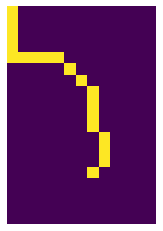

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(sample_df.values, interpolation='nearest')
plt.axis('off')
plt.show()

Load all the training paths

In [5]:
def loadData(path=data_path):
    files = os.listdir(path)
    data = []
    labels = []
    for fn in files:
        ffn = os.path.join(path, fn)
        df = pd.read_csv(ffn, index_col=None, header=None)
        df[df==2]=0
        data.append(df.values)
        label = int(fn[0:2])
        labels.append(label)
    data = np.array(data) 
    return data, labels

In [6]:
data, labels = loadData() 

In [7]:
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


### Load defined path classes ad their specification:
We have 6 classes. (x1,y1) and (x2,y2) specify tow end of the path.  

In [8]:
defined_path_classes = pd.read_csv("D:\ML\PATHGAN\input\pathClasses.csv", index_col=None)
defined_path_classes

,class,x1,y1,x2,y2
0,0,0,0,14,7
1,1,0,0,16,12
2,2,2,5,16,12
3,3,2,5,16,8
4,4,2,5,18,0
5,5,4,0,10,10


# Create GAN structure

In [9]:
class GAN():
    def __init__(self, img_rows=19, img_cols=13, channels=1):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        noise_shape = (100,)

        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        #model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)

        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        #model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, X_train, y_, epochs=1000, batch_size=2):

        X_train = 2 * (X_train.astype(np.float32)) - 1
        X_train = np.expand_dims(X_train, axis=3)
        half_batch = int(batch_size / 2)

        for epoch in tqdm.trange(epochs, desc='Training'):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)
            
        
    
    def save_pgan_model(self):
        self.generator.save_weights('D:\ML\PATHGAN\PathGANckpt.ckpt')
        self.generator.save('D:\ML\PATHGAN\PathGAN.h5')
        
        
    def load_pgan_model(self):
        self.generator = tf.keras.models.load_model('D:\ML\PATHGAN\PathGAN.h5')
        #self.generator.load_weights('D:\ML\PATHGAN\PathGANckpt.ckpt')
        print("Loaded the model from file")
        self.generator.summary()

### Build and Train the GAN

In [10]:
gan = GAN()
start_time = time.time()
#gan.train(data, labels, epochs=10000, batch_size=8)
#gan.save_pgan_model()
print("total training time: %s seconds ---" % (time.time() - start_time))

total training time: 0.0 seconds ---


Generate 12 paths from noise vectors of size 100.

In [11]:
gan.load_pgan_model()

Loaded the model from file
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 19, 13, 1)         943095    
Total params: 943,095
Trainable params: 939,511
Non-trainable params: 3,584
_________________________________________________________________


In [23]:
gen_samples_row, gen_samples_col = 1,1
count = gen_samples_row*gen_samples_col
noise = np.random.normal(0, 1, (count, 100))
print(noise.shape)

(1, 100)


A noise vector:

In [24]:
noise[0]

array([ 1.69052570e+00, -4.65937371e-01,  3.28201637e-02,  4.07516283e-01,
       -7.88923029e-01,  2.06557291e-03, -8.90385858e-04, -1.75472431e+00,
        1.01765801e+00,  6.00498516e-01, -6.25428974e-01, -1.71548261e-01,
        5.05299374e-01, -2.61356415e-01, -2.42749079e-01, -1.45324141e+00,
        5.54580312e-01,  1.23880905e-01,  2.74459924e-01, -1.52652453e+00,
        1.65069969e+00,  1.54335535e-01, -3.87139943e-01,  2.02907222e+00,
       -4.53860299e-02, -1.45067870e+00, -4.05227855e-01, -2.28831510e+00,
        1.04939655e+00, -4.16474319e-01, -7.42553525e-01,  1.07247013e+00,
       -1.65107559e+00,  5.35429356e-01, -2.06441480e+00, -6.62159340e-01,
       -1.20421985e+00,  1.46197563e+00,  1.76616088e+00, -3.29413752e-01,
        8.40733242e-01, -1.79986401e-01,  5.68061887e-01, -7.52837196e-01,
       -1.70833920e+00, -1.80309866e+00,  3.83121852e-01,  2.24759505e+00,
        2.69411631e-01, -5.24604619e-01,  1.91201886e+00,  2.37301847e-01,
        1.01433985e-01,  

In [25]:
# Generate images from noise data
gen_imgs = gan.generator.predict(noise)
print(gen_imgs.shape)

(1, 19, 13, 1)


Rescale image pixels in 0 - 1

In [26]:
gen_imgs = 0.5 * gen_imgs + 0.5

Shape of a generated image:

In [27]:
gen_imgs[0].shape

(19, 13, 1)

Show the generated paths

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(gen_imgs[0], interpolation='nearest')
plt.axis('off')
plt.show()

TypeError: 'AxesSubplot' object is not subscriptable

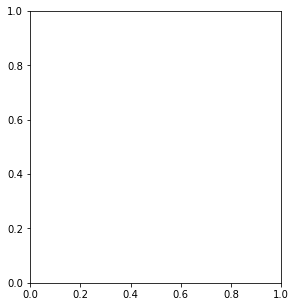

In [28]:
fig, axs = plt.subplots(gen_samples_row, gen_samples_col, figsize=(4.5,5))
cnt = 0
fig.subplots_adjust(hspace=0.5)
for i in range(gen_samples_row):
    for j in range(gen_samples_col):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap=plt.cm.gray)
        axs[i,j].axis('off')
    autoAxis = axs[i,j].axis()
    rec = Rectangle((autoAxis[0]-0.1,autoAxis[2]-0.2),(autoAxis[1]-autoAxis[0])+.2,(autoAxis[3]-autoAxis[2])+0.1,fill=False, lw=0.5)
    rec = axs[i,j].add_patch(rec)
    rec.set_clip_on(False)
    cnt += 1
plt.show()
plt.close()

After generating paths, we need to identify the class of generated path so we can check if they are what we expected.

## Create Path Classifier

In [18]:
class PathClassifier:
    
    def __init__(self, num_pixels=13*19, num_classes=6):
        self.model = self.build_classifier_base(num_pixels, num_classes)

    def build_classifier_base(self, num_pixels, num_classes):
        # fix random seed for reproducibility
        seed = 7
        np.random.seed(seed)
        model = Sequential()
        model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
        # Compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    def train_model(self, X_train, y_train, eps=10, batch_size=20):
        num_classes = y_train.shape[1]
        num_pixels = X_train.shape[1]        
        self.model.fit(X_train, y_train, epochs=eps, batch_size=batch_size, verbose=2)
        return self.model

    def evaluate(self, X_test, y_test):        
        scores = self.model.evaluate(X_test, y_test, verbose=0)
        accuracy = scores[1] * 100
        print("Classification accuracy: %.2f%%" % accuracy)
        return accuracy

### Train the path classifier

In [19]:
path_classifier = PathClassifier()
lblEnc = LabelEncoder()
labels = lblEnc.fit_transform(labels)

num_pixels = data.shape[1] * data.shape[2]
data = data.reshape(data.shape[0], num_pixels).astype('float32')
labels = np_utils.to_categorical(labels)

num_classes = labels.shape[1]

lnx = int(len(data) * 0.7)
X_train, X_test = data[:lnx], data[lnx:]
y_train, y_test = labels[:lnx], labels[lnx:]

path_classifier.train_model(X_train, y_train, eps=10, batch_size=i*10)


Epoch 1/10
11/11 - 0s - loss: 1.5637 - accuracy: 0.4886
Epoch 2/10
11/11 - 0s - loss: 1.1083 - accuracy: 0.7717
Epoch 3/10
11/11 - 0s - loss: 0.7394 - accuracy: 0.8995
Epoch 4/10
11/11 - 0s - loss: 0.4671 - accuracy: 0.9543
Epoch 5/10
11/11 - 0s - loss: 0.3052 - accuracy: 0.9543
Epoch 6/10
11/11 - 0s - loss: 0.2075 - accuracy: 0.9817
Epoch 7/10
11/11 - 0s - loss: 0.1532 - accuracy: 0.9863
Epoch 8/10
11/11 - 0s - loss: 0.1157 - accuracy: 0.9909
Epoch 9/10
11/11 - 0s - loss: 0.0948 - accuracy: 0.9863
Epoch 10/10
11/11 - 0s - loss: 0.0759 - accuracy: 0.9909


How accurate is our path classifier?

In [20]:
path_classifier.evaluate(X_test, y_test)

Classification accuracy: 43.62%


43.6170220375061

Now we can identify the class of generated paths

In [21]:
gen_imgs2 = gen_imgs.reshape(gen_imgs.shape[0], gen_imgs.shape[1]*gen_imgs.shape[2]).astype('float32')
classes = path_classifier.model.predict(gen_imgs2)
classes = np.argmax(classes, axis=1)

Draw generated paths and their class label

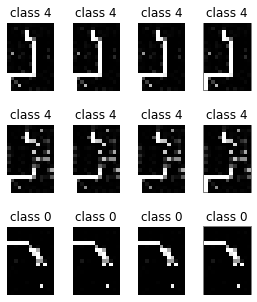

In [22]:
fig, axs = plt.subplots(gen_samples_row, gen_samples_col, figsize=(4.5,5))
cnt = 0
fig.subplots_adjust(hspace=0.5)
for i in range(gen_samples_row):
    for j in range(gen_samples_col):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap=plt.cm.gray)
        axs[i,j].set_title('class ' + str(classes[cnt]))
        axs[i,j].axis('off')
    autoAxis = axs[i,j].axis()
    rec = Rectangle((autoAxis[0]-0.1,autoAxis[2]-0.2),(autoAxis[1]-autoAxis[0])+.2,(autoAxis[3]-autoAxis[2])+0.1,fill=False, lw=0.5)
    rec = axs[i,j].add_patch(rec)
    rec.set_clip_on(False)
    cnt += 1
plt.show()
plt.close()

In [ ]:
 =-